In [1]:
from quadmodel.quadmodel import QuadLensSystem   
from quadmodel.deflector_models.power_law_shear import PowerLawShear
from quadmodel.macromodel import MacroLensModel
from quadmodel.data import Quad as LensedQuasar
from quadmodel.deflector_models.sis import SIS
from quadmodel.Solvers.hierachical import HierarchicalOptimization
from quadmodel.Solvers.brute import BruteOptimization

from pyHalo.preset_models import CDM
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

x_image = np.array([-0.347, -0.734, -1.096, 0.207])
y_image = np.array([0.964, 0.649, -0.079, -0.148])
magnifications = np.array([[0.88, 1., 0.474, 0.025]])

data = LensedQuasar(x_image, y_image, magnifications)
zlens, zsource = 0.45, 1.69

In [2]:
realization = CDM(zlens, zsource)

kwargs_macromodel = [{'theta_E': 1., 'center_x': 0., 'center_y': -0.0, 'e1': 0.1, 'e2': 0.2, 'gamma': 2.0}, 
               {'gamma1': 0.0, 'gamma2': 0.0}]

main_lens_fit = PowerLawShear(zlens, kwargs_macromodel)
macromodel = MacroLensModel([main_lens_fit])
lens_system = QuadLensSystem.shift_background_auto(data, macromodel, zsource, realization)


In [3]:
verbose = True # this will print the output from the fitting process. Set it to False to save space if you want
optimizer = HierarchicalOptimization(lens_system)
kwargs_lens_final, lens_model_full, return_kwargs = optimizer.optimize(data, constrain_params=None,
                                                   param_class_name='free_shear_powerlaw',
                                                                       verbose=verbose)

optimization 1
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  73
N subhalos:  222
10
20
30
40
50
60
70
80
90
100
110
PSO done... 
source plane chi^2:  76941.70611938884
total chi^2:  76941.70611938884
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.34037495, -0.34037514, -0.34037487, -0.340375  ]), array([0.25109584, 0.25109574, 0.25109582, 0.25109593]))
optimization 2
aperture size:  0.2
minimum mass in aperture:  0.0
minimum global mass:  7.0
N foreground halos:  79
N subhalos:  261
starting amoeba... 
optimization done.
Recovered source position:  (array([-0.34068554, -0.34068561, -0.34068568, -0.34068547]), array([0.25111074, 0.25111076, 0.25111075, 0.25111093]))
optimization 1
nhalos:  308
aperture size:  100
minimum mass in aperture:  7.0
minimum global mass:  7.0
N foreground halos:  79
N subhalos:  261
N background halos:  229
starting amoeba... 
optimization done.
Recovered source position:  (arra

[0.81690029 1.         0.51388162 0.02195814]
[[0.88  1.    0.474 0.025]]


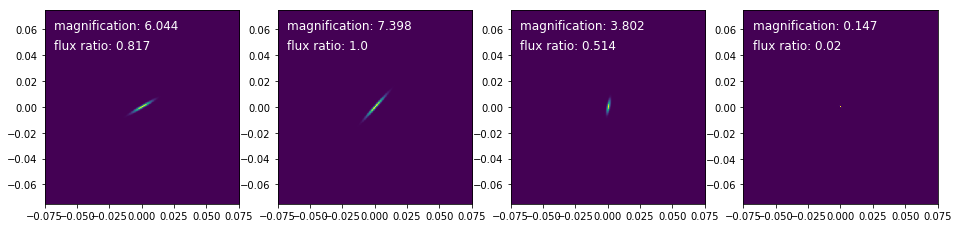

In [4]:
lensmodel, kwargs = lens_system.get_lensmodel()
source_size = 15 # parsec
flux_ratios = lens_system.quasar_magnification(data.x, 
                                     data.y, source_size, lens_model=lensmodel, 
                                   kwargs_lensmodel=kwargs, grid_axis_ratio=0.5, 
                                   grid_resolution_rescale=2., source_model='GAUSSIAN')

print(flux_ratios)
print(data.m)

lens_system.plot_images(data.x, data.y, source_size, lens_model=lensmodel, 
                               kwargs_lensmodel=kwargs, source_model='GAUSSIAN')

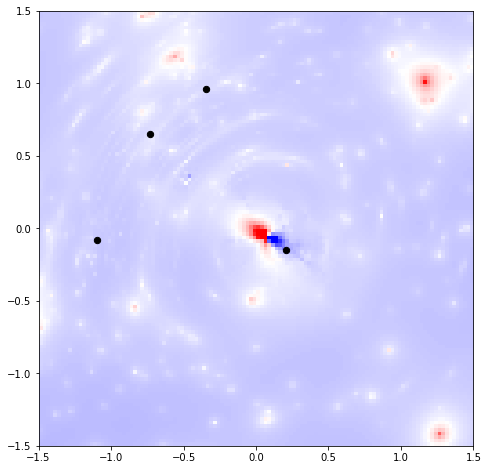

In [5]:
lens_system_smooth = lens_system.get_smooth_lens_system()
lensmodel_smooth, kwargs_smooth = lens_system_smooth.get_lensmodel()

npix = 120
ran = 1.5
_x = np.linspace(-ran, ran, npix)
xx, yy = np.meshgrid(_x, _x)
shape0 = xx.shape
kappa_full = lensmodel.kappa(xx.ravel(), yy.ravel(), kwargs).reshape(shape0)
kappa_macro = lensmodel_smooth.kappa(xx.ravel(), yy.ravel(), kwargs_smooth).reshape(shape0)
substructure_convergence = kappa_full - kappa_macro

fig = plt.figure(1)
fig.set_size_inches(8, 8)
plt.imshow(substructure_convergence, vmin=-0.1, vmax=0.1, cmap='bwr', origin='lower',
          extent=[-ran, ran, -ran, ran])
plt.scatter(data.x, data.y, color='k', s=40)